## Exercise 2e)

In this notebook, we do a regression analysis with $L1$ and $L2$ regularization terms.The goal is to find the optimal values of the hyperparameters, including the regularization parameter and model architecture. We first evaluate the testing MSE as a function of the learning rate and regularization parameter in order to find the optimal pair of these values. With that optimal pair, we can then evaluate the MSE as a function of model architecture (number of hidden layers, nodes in each layer and activation function). 

The first figure is then figure 5 from the report. 

In [ ]:
LOAD_FROM_FILE = True   #  load data from file, so the bottlenecks of the program run in just a few seconds

In [88]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity, ReLU, LeakyReLU
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from utils.utils import generate_dataset, runge, plot_mse_data, analyze_model_learning_rates, r2, skip_if
import pickle
from copy import deepcopy

plt.style.use('./utils/_plot_style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)

# Scale dataset
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_mean = y_train.mean()

In [ ]:
# define activation functions, the type of regularization (L1 or L2), as well as training method and step method (Adam SGD). 

activation_funcs = [
    ("Sigmoid", Sigmoid()),
    ("ReLU", ReLU()), 
    ("LeakyReLU",LeakyReLU())
]

regularization_types = [
    ("Lasso","L1"), 
    ("Ridge","L2")
]

training_methods = ("SGD", StochasticGradientDescent, (-4, 1))
step_methods = ("ADAM", AdamStep(0, 0.9, 0.999))

# define a feq auxiliary variables, including the range of learning rate values and lambda values. 
n_learning_rates = 8
iterations = 3000
lamb_vals = np.logspace(-3,1,9)
all_mse_data_1 = np.zeros((len(lamb_vals), len(regularization_types), n_learning_rates))
n_layers = 1
n_nodes = 40
activation_func = Sigmoid()
_,training_method, (min_log_lr,max_log_lr) = training_methods
learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

In [ ]:
%%skip_if LOAD_FROM_FILE

# Analyze mse vs. learning rate and regularization parameter
for i, lamb in enumerate(lamb_vals):
    for j,(name,regularization) in enumerate(regularization_types): 
        print("Lambda: ",lamb_vals)

        model = NeuralNetwork(
                network_input_size = 1,
                layer_output_sizes = [n_nodes]*n_layers + [1],
                activation_funcs = [activation_func]*n_layers + [Identity()],
                cost_fun = MSE(regularization = regularization,lambd = lamb), 
                layers_random_state = 23
                )

        np.random.seed(124)
        mse_data = analyze_model_learning_rates(
            model,
            training_method(
                step_method = step_methods[1],
                inputs = x_train_scaled,
                targets = y_train - y_mean,
                test_inputs = x_test_scaled,
                test_targets = y_test - y_mean,
            ),
            learning_rates, 
            iterations,
        )
        print(".")
        all_mse_data_1[i][j] = mse_data

In [92]:
filepath = "../data/mse_vs_lr_nodes_reg_final.npy"

# Save data to file
#np.save(filepath, all_mse_data_1)

# Load data from file
if LOAD_FROM_FILE:
    all_mse_data_1 = np.load(filepath)

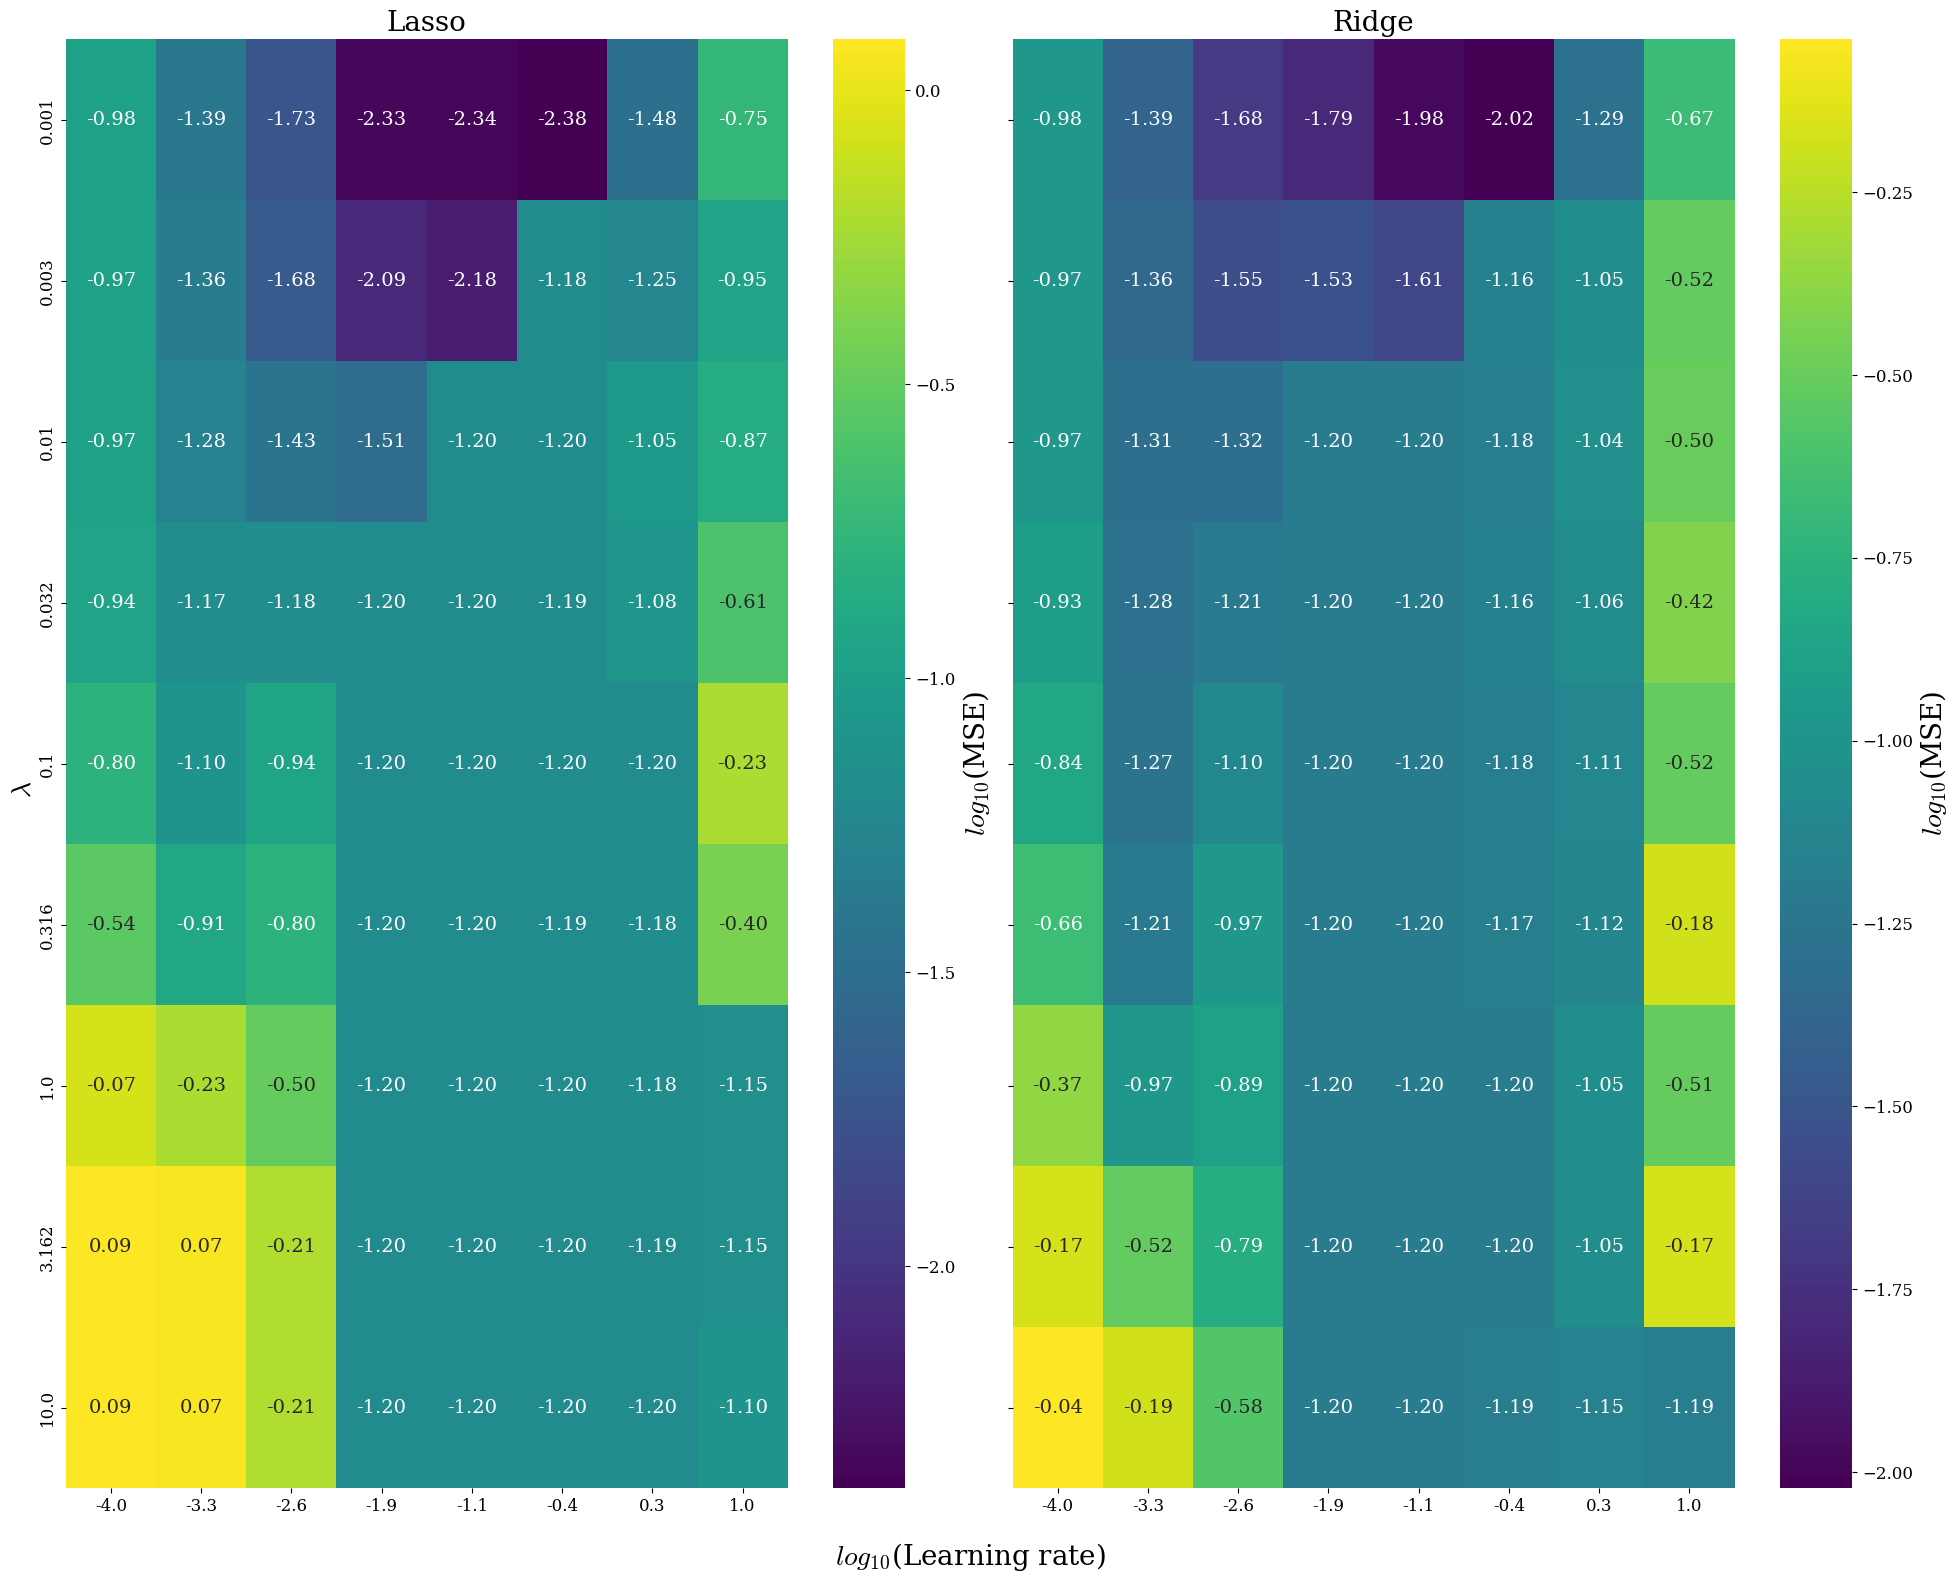

In [ ]:
# Plot MSE vs. learning rate and lambda for L1 and L2 regularization. 

import seaborn as sns

fig, axes = plt.subplots(1, len(regularization_types), figsize=(20, 16), sharey=True)
for i,(name,regularization_type) in enumerate(regularization_types):
    mse_data = all_mse_data_1[:,i,:]
    ax = sns.heatmap(
        np.log10(np.array(mse_data)),  
        ax = axes[i],
        fmt=".2f",   
        annot=True,
        cmap="viridis", 
        xticklabels=np.round(np.log10(np.array(learning_rates)),1),
        yticklabels=np.round(lamb_vals,3),cbar_kws={"label": r"$log_{10}$(MSE)"}
        )
    axes[i].set_title(f"{name}",fontsize = 20)
    cbar = ax.collections[0].colorbar
    cbar.set_label(r"$log_{10}$(MSE)", fontsize=20)


fig.supxlabel(r"$log_{10}$(Learning rate)",fontsize = 20)
fig.supylabel(r"$\lambda$",fontsize = 20)
plt.savefig("../figs/mse_vs_lr_nodes_reg(2).pdf")
plt.show()

Then, the analysis of the testing MSE as a function of model architecture follows below. Here, we create figure 6 from the report. We use the optimal value of $\lambda$ and the learning rate that we found above. 

In [ ]:
# interval of values for the number of nodes and number of hidden layers 
nodes = list(range(10,86,15))
hidden_layers = [1,3,5]

iterations = 3000
all_mse_data_2 = np.zeros((len(nodes), len(hidden_layers), len(activation_funcs),len(regularization_types)))
single_learning_rate = []

In [ ]:
%%skip_if LOAD_FROM_FILE

# Analyze testing mse vs. hidden layer and number of nodes for different activation functions and regularization types. 
for i, n_nodes in enumerate(nodes):
    print("\nNode: ",n_nodes, end="")
    for j, n_hidden_layers in enumerate(hidden_layers):
        for k, (name,activation_func) in enumerate(activation_funcs):
            for l,(name,regularization) in enumerate(regularization_types): 

                model = NeuralNetwork(   # define the NN model
                        network_input_size = 1,
                        layer_output_sizes = [n_nodes]*n_hidden_layers  + [1],
                        activation_funcs = [activation_func]*n_hidden_layers + [Identity()],
                        cost_fun = MSE(regularization = regularization, lambd = 0.001), 
                        layers_random_state = 23
                        )

                np.random.seed(124)
                mse_data = analyze_model_learning_rates(    # train the model, return the testing MSE
                    model,
                    training_method(
                        step_method = step_methods[1],
                        inputs = x_train_scaled,
                        targets = y_train - y_mean,
                        test_inputs = x_test_scaled,
                        test_targets = y_test - y_mean,
                    ),
                    [learning_rates[5]], 
                    iterations,
                )
                print(".",end="")
                all_mse_data_2[i][j][k][l] = mse_data[0]

In [96]:
filepath = "../data/mse_vs_hidden_layer_nodes_reg_final.npy"

# Save data to file
#np.save(filepath, all_mse_data_2)

# Load data from file
if LOAD_FROM_FILE:
    all_mse_data_2 = np.load(filepath)

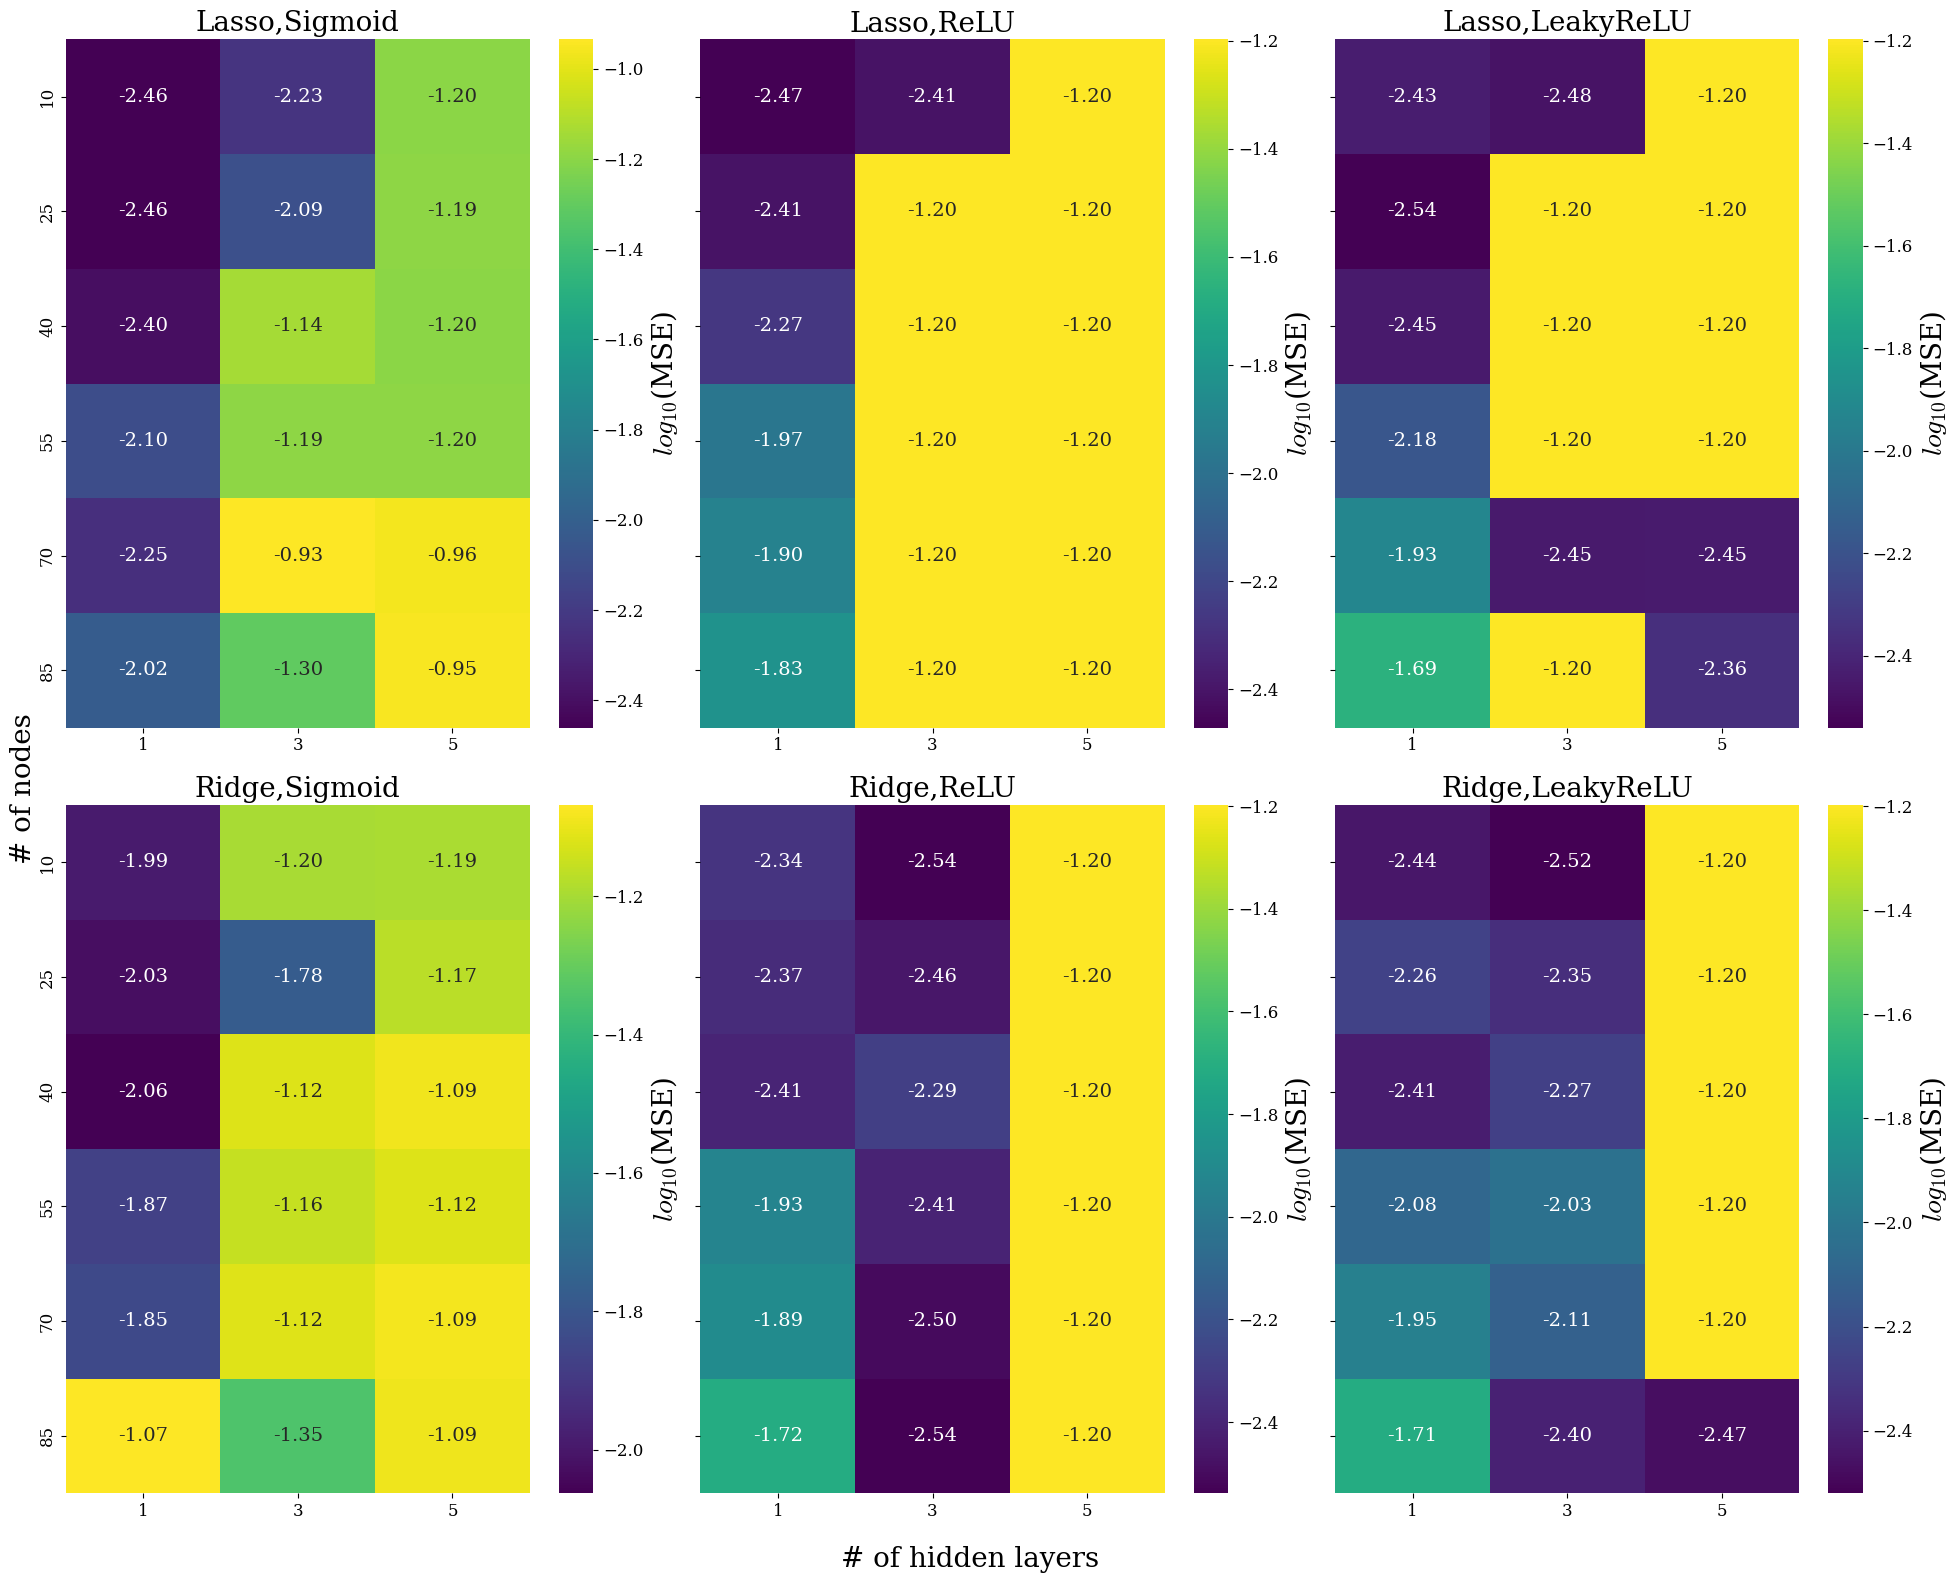

In [ ]:
import seaborn as sns

# Plot MSE vs number of nodes and hidden layers, for different activation functions and regularization types. 

fig, axes = plt.subplots(len(regularization_types),len(activation_funcs), figsize=(20, 16), sharey=True)
for l,(reg_name,regularization) in enumerate(regularization_types):
    for k, (act_name,activation_func) in enumerate(activation_funcs):
        mse_data = all_mse_data_2[:,:,k,l]
        ax = sns.heatmap(
            np.log10(np.array(mse_data)),  
            ax = axes[l,k],
            fmt=".2f",   
            annot=True,
            cmap="viridis", 
            xticklabels=hidden_layers,
                                              #vmin = np.log10(np.min(all_mse_data[:,j,:,:])), vmax = np.log10(np.max(all_mse_data[:,j,:,:])),
            yticklabels=nodes,cbar_kws={"label": r"$log_{10}$(MSE)"}
            )
        axes[l,k].set_title(fr"{reg_name},{act_name}",fontsize = 20)
        cbar = ax.collections[0].colorbar
        cbar.set_label(r"$log_{10}$(MSE)", fontsize=20)

    fig.supxlabel(r"# of hidden layers",fontsize = 20)
    fig.supylabel("# of nodes",fontsize = 20)
plt.savefig("../figs/mse_vs_nodes_hidden_layers(2).pdf")
plt.show()

Finally, once the optimal model architecture and regularization parameter has been found, we do a cross validation to evaluate the performance in terms of the R^2 score. We compare with the R^2 score from scikit-learn's $\texttt{linear\_model}$ that implements linear regression with a polynomial fit of degree 12. 

In [ ]:
# define cross validation split, as well as Lasso and Ridge models

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=44)
scaler = StandardScaler()
nn_mse = np.zeros((2,n_splits))
scikit_mse = np.zeros((2,n_splits))

# Lasso model
lasso_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    linear_model.Lasso(alpha = 0.001, fit_intercept=False,max_iter = 20000)
)

# Ridge model
ridge_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    linear_model.Ridge(alpha = 0.001,fit_intercept=False)
)

models = [lasso_model,ridge_model]

activation_funs = [LeakyReLU(),ReLU()]

n_hidden_layers = [1,3]
n_nodes = [25,10]

In [ ]:
%%skip_if LOAD_FROM_FILE

# Evaluate the testing MSE on each fold, for neural network and linear regression models. 

for l,(name,regularization) in enumerate(regularization_types): 
    nn_model = NeuralNetwork(
    1,
    [n_nodes[l]]*n_hidden_layers[l] + [1],
    [activation_funs[l]]*n_hidden_layers[l] + [Identity()],
    MSE(regularization = regularization, lambd = 0.001),
    )
    for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Scale data
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        y_mean = y_train.mean()

        # Train and evaluate Neural Network
        nn_model.reset_layers(random_state=123) # Reset neural network layers
        mse_data = nn_model.train(    # train neural network
            StochasticGradientDescent(
                step_method = AdamStep(learning_rate=learning_rates[5]),
                inputs = x_train_scaled,
                targets = y_train - y_mean,
                test_inputs = x_test_scaled,
                test_targets = y_test - y_mean
            ),
            num_iterations = 3000,
            track_mse = True
        )

        # predict on neural network
        y_pred_nn = nn_model.predict(x_test_scaled) + y_mean
        nn_mse[l,fold_idx] = MSE()(y_pred_nn, y_test)

        # Train and evaluate Ridge and Lasso regression model
        model = models[l]
        model.fit(x_train_scaled, y_train - y_mean)
        y_pred = model.predict(x_test_scaled) + y_mean
        scikit_mse[l,fold_idx] = MSE()(y_pred, y_test)

In [100]:
filepath = "../data/nn_scikit_mse_final.npz"

# Save data to file
#np.savez(filepath, array1 = nn_mse, array2 = scikit_mse)

# Load data from file
if LOAD_FROM_FILE:
    nn_mse = np.load(filepath)["array1"]
    scikit_mse = np.load(filepath)["array2"]

In [ ]:
# Print final R^2 scores

print("Neural network R^2 score for cross validation with optimal hyperparameters, L1 regularization (Lasso): ",r2(np.mean(nn_mse[0]),y))
print("Lasso regression R^2 score for cross validation: ",r2(np.mean(scikit_mse[0]),y))
print("")
print("Neural network MSE for cross validation with optimal hyperparameters, L2 regularization (Ridge): ",r2(np.mean(nn_mse[1]),y))
print("Ridge regression MSE for cross validation: ",r2(np.mean(scikit_mse[1]),y))

Neural network R^2 score for cross validation with optimal hyperparameters, L1 regularization (Lasso):  0.935708494248408
Lasso regression R^2 score for cross validation:  -0.7617988021208004

Neural network MSE for cross validation with optimal hyperparameters, L2 regularization (Ridge):  0.95854816489169
Ridge regression MSE for cross validation:  -0.89436286644674
